In [88]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import corner
import time
import pickle
import imageio as iio
from datetime import date

In [89]:
# model_teff_logg_feh = '5000_3.50_0.00'

model_teff_logg_feh = '5750_4.50_0.00'

In [90]:
file_opener = open('../spectrum_interpolation/training_input/'+model_teff_logg_feh+'/galah_dr4_trainingset_'+model_teff_logg_feh+'_incl_vsini_flux_ivar.pickle','rb')
flux = pickle.load(file_opener)
file_opener.close()

wavelength_file_opener = open('../spectrum_interpolation/training_input/galah_dr4_3dbin_wavelength_array.pickle','rb')
wavelength_array = pickle.load(wavelength_file_opener)
wavelength_file_opener.close()

Text(0, 0.5, 'Flux(Norm)')

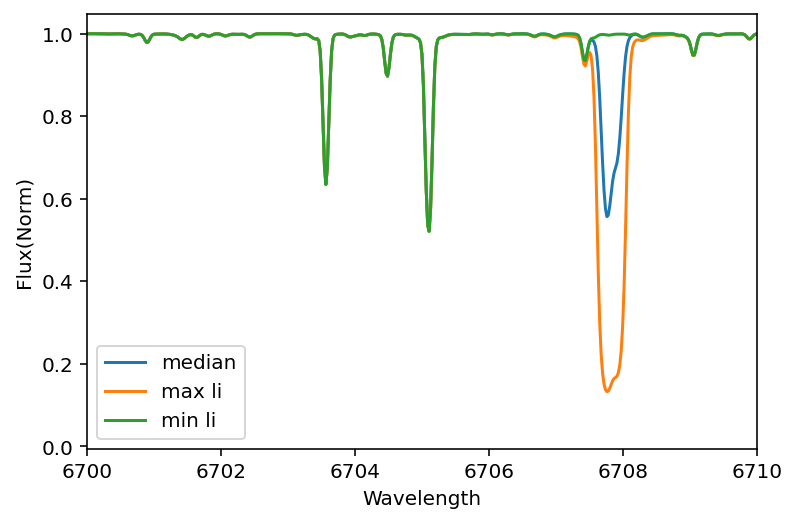

In [91]:
plt.plot(
    wavelength_array,
    flux[0,:],
    label='median'
)
plt.plot(
    wavelength_array,
    flux[6,:],
    label='max li'
)
plt.plot(
    wavelength_array,
    flux[6+35,:],
    label='min li'
)
plt.legend()
plt.xlim(6700,6710)
plt.xlabel('Wavelength')
plt.ylabel('Flux(Norm)')

In [92]:
labels = Table.read('../spectrum_interpolation/training_input/'+model_teff_logg_feh+'/galah_dr4_trainingset_'+model_teff_logg_feh+'_incl_vsini.fits')

Text(0, 0.5, 'Flux(norm)')

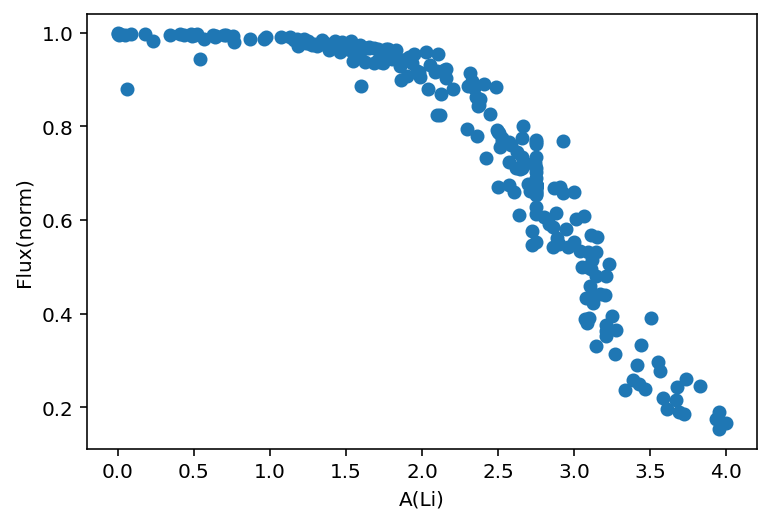

In [93]:
ranges = (labels['vsini'] == 1.5)# & (labels['logg'] < 3.6) & (labels['logg'] > 3.4)  & (labels['fe_h'] < 0.05) & (labels['fe_h'] > -0.05) 

plt.scatter(
    labels['li_fe'][ranges] + labels['fe_h'][ranges] + 1.05,
    flux[ranges,45943]
)
plt.xlabel('A(Li)')
plt.ylabel('Flux(norm)')

In [94]:
galah_dr4_directory = '/avatar/buder/GALAH_DR4/'

In [8]:
model_name = galah_dr4_directory+'spectrum_interpolation/neural_networks/models/galah_dr4_neutral_network_3x3x3_'+model_teff_logg_feh+'_36labels.npz'
tmp = np.load(model_name)
w_array_0 = tmp["w_array_0"]
w_array_1 = tmp["w_array_1"]
w_array_2 = tmp["w_array_2"]
b_array_0 = tmp["b_array_0"]
b_array_1 = tmp["b_array_1"]
b_array_2 = tmp["b_array_2"]
x_min = tmp["x_min"]
x_max = tmp["x_max"]
tmp.close()
neural_network_model_300 = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)

In [33]:
np.shape(w_array_0),np.shape(w_array_1),np.shape(w_array_2),np.shape(b_array_0),np.shape(b_array_1),np.shape(b_array_2)

((300, 36), (300, 300), (64224, 300), (300,), (300,), (64224,))

In [38]:
b_array_2[0]

0.079236545

[5.7500000e+03 4.5000000e+00 0.0000000e+00 1.5000000e+00 9.7500000e-04
 3.0818553e+00 2.5000000e-01 2.5000000e-01 2.5000000e-01 0.0000000e+00
 2.5000000e-01 0.0000000e+00 2.5000000e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 2.5000000e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 2.5000000e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 2.5000000e-01 2.5000000e-01 2.5000000e-01 2.5000000e-01 0.0000000e+00
 0.0000000e+00]


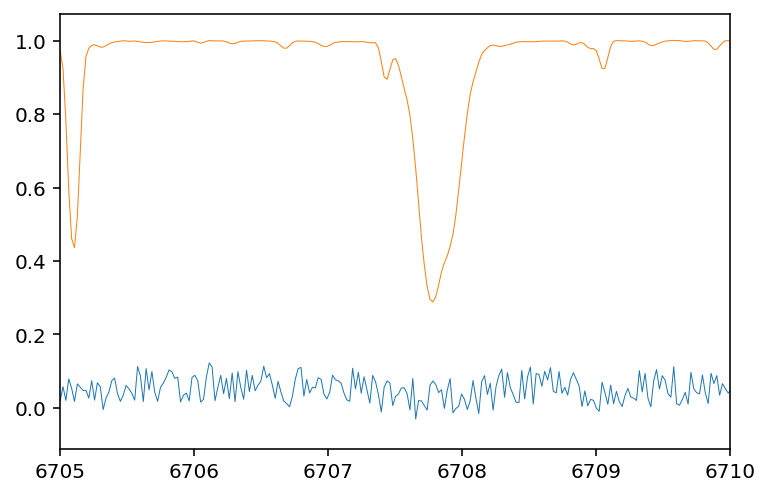

In [86]:
plt.plot(
    wavelength_array,
    b_array_2,
    lw = 0.5
)

scaled_labels = np.zeros(36)
scaled_labels[4] -= 0.54345
scaled_labels[5] = +0.5

print((scaled_labels + 0.5) * (neural_network_model_300[-1]-neural_network_model_300[-2]) + neural_network_model_300[-2])

plt.plot(
    wavelength_array,
    get_spectrum_from_neural_net(scaled_labels,neural_network_model_300),
    lw = 0.5
)

plt.xlim(6705,6710)
plt.show()
plt.close()

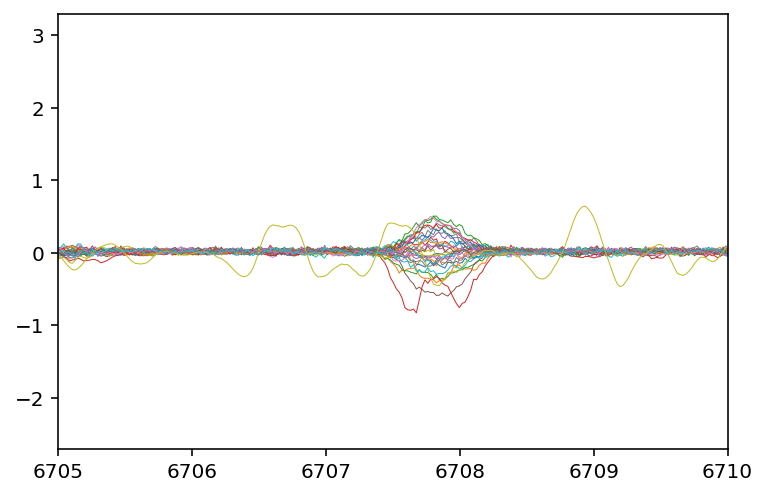

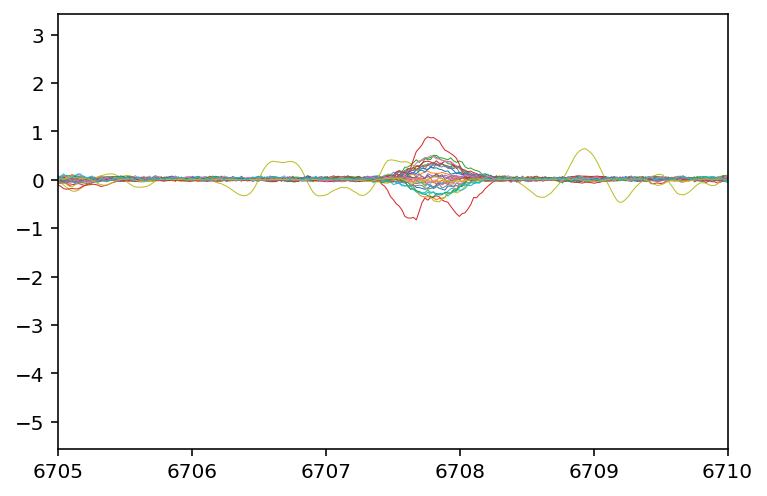

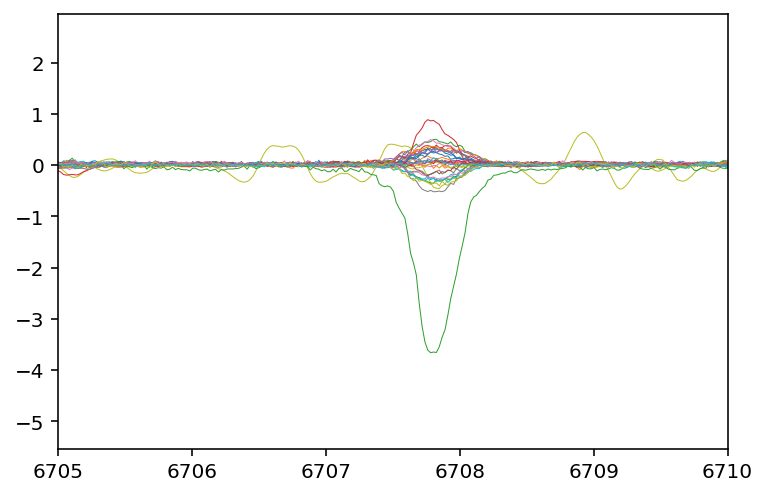

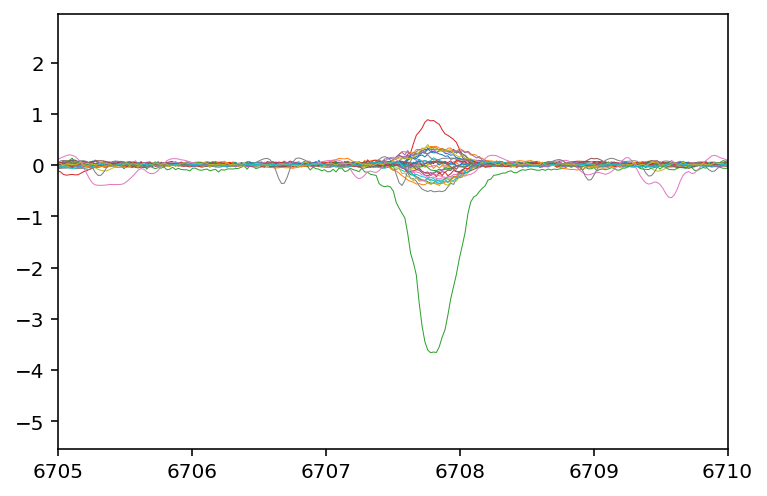

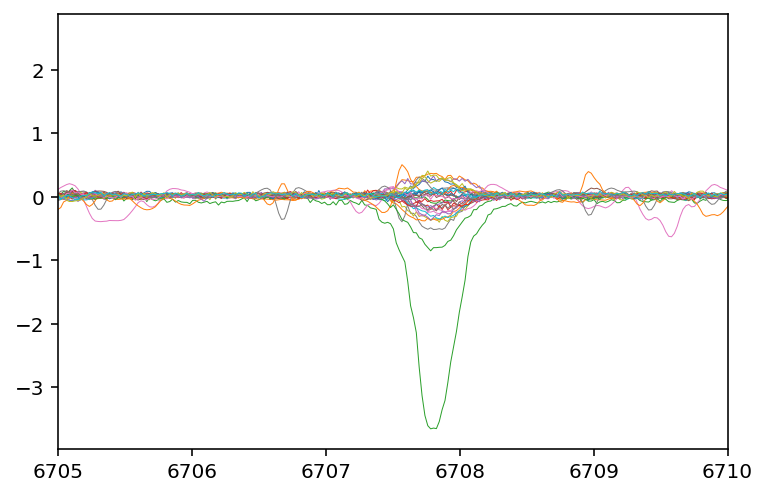

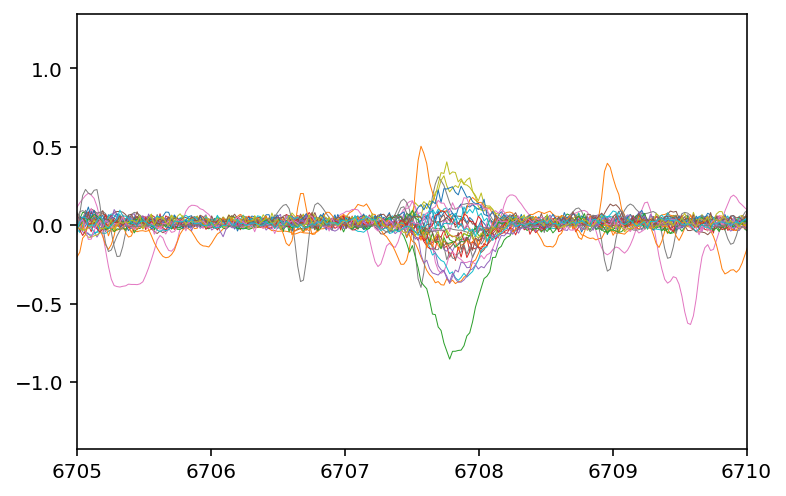

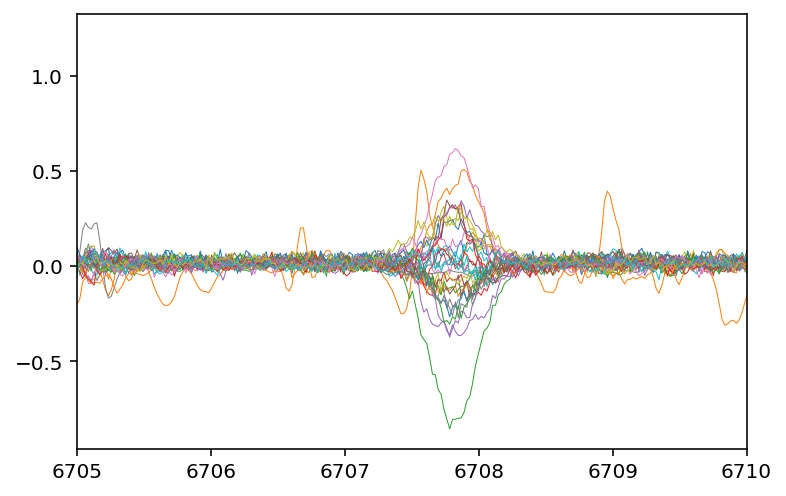

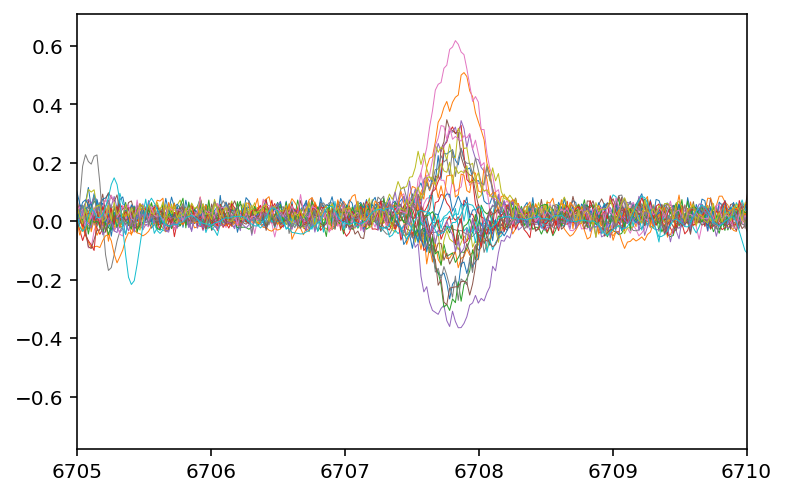

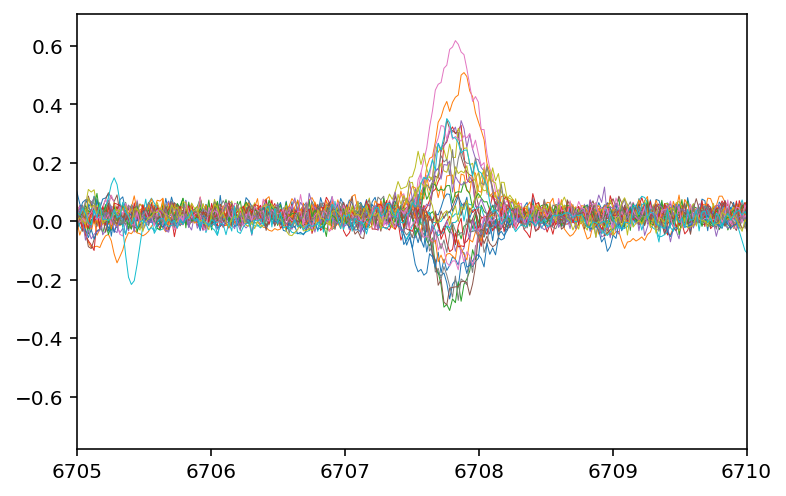

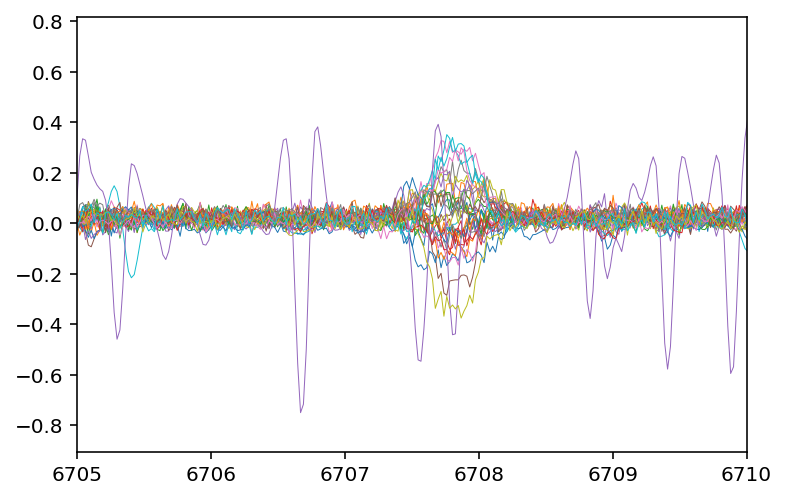

In [87]:
for x in range(10):
    plt.figure()
    for y in range(30):
        plt.plot(
            wavelength_array,
            w_array_2[:,x*10+y],
            lw = 0.5
        )
        #plt.xlim(6400,6800)
        plt.xlim(6705,6710)
    plt.show()
    plt.close()

In [98]:
def leaky_relu(z):
    return z*(z > 0) + 0.01*z*(z < 0)

def get_spectrum_from_neural_net(scaled_labels, NN_coeffs, layer = 2):
    if layer == 2:
        w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max = NN_coeffs
        inside = np.einsum('ij,j->i', w_array_0, scaled_labels) + b_array_0
        outside = np.einsum('ij,j->i', w_array_1, leaky_relu(inside)) + b_array_1
        spectrum = np.einsum('ij,j->i', w_array_2, leaky_relu(outside)) + b_array_2
        return spectrum
    elif layer == 3:
        w_array_0, w_array_1, w_array_2, w_array_3, b_array_0, b_array_1, b_array_2, b_array_3, x_min, x_max = NN_coeffs
        inside = np.einsum('ij,j->i', w_array_0, scaled_labels) + b_array_0
        outside1 = np.einsum('ij,j->i', w_array_1, leaky_relu(inside)) + b_array_1
        outside2 = np.einsum('ij,j->i', w_array_2, leaky_relu(outside1)) + b_array_2
        spectrum = np.einsum('ij,j->i', w_array_3, leaky_relu(outside2)) + b_array_3
        return spectrum
    else:
        raise ValueError('Layer must be 2 or 3')

In [142]:
def plot_fluxes_and_return_them(model_name):
    
    print(model_name)
    
    if '2layers' in model_name:
        tmp = np.load('../spectrum_interpolation/neural_networks/models/'+model_name)
        w_array_0 = tmp["w_array_0"]
        w_array_1 = tmp["w_array_1"]
        w_array_2 = tmp["w_array_2"]
        b_array_0 = tmp["b_array_0"]
        b_array_1 = tmp["b_array_1"]
        b_array_2 = tmp["b_array_2"]
        x_min = tmp["x_min"]
        x_max = tmp["x_max"]
        tmp.close()
        neural_network_model = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)
        
    else:
        raise ValueError('prepare 3 layer case')
        
    start = time.time()
    nn_fluxes = []

    for i in range(280):#len(labels)):
        model_labels = np.array([labels[i][x] for x in range(2,38)])

        scaled_labels = (model_labels-neural_network_model[-2])/(neural_network_model[-1]-neural_network_model[-2]) - 0.5
        nn_fluxes.append(get_spectrum_from_neural_net(scaled_labels,neural_network_model))

    nn_fluxes = np.array(nn_fluxes)
    print(time.time()-start)
    
    f, gs = plt.subplots(1,3,figsize=(15,5))

    ax = gs[0]
    ax.plot(
        wavelength_array,
        flux[0,:],
        label='median'
    )
    ax.plot(
        wavelength_array,
        flux[6,:],
        label='max li'
    )
    ax.plot(
        wavelength_array,
        flux[6+35,:],
        label='min li'
    )
    ax.legend()
    ax.set_xlim(6700,6710)
    ax.set_ylim(-0.3,1.3)
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Flux(Norm)')

    ax = gs[1]
    ax.plot(
        wavelength_array,
        nn_fluxes[0,:],
        label='median'
    )
    ax.plot(
        wavelength_array,
        nn_fluxes[6,:],
        label='max li'
    )
    ax.plot(
        wavelength_array,
        nn_fluxes[6+35,:],
        label='min li'
    )
    ax.legend()
    ax.set_xlim(6700,6710)
    ax.set_ylim(-0.3,1.3)
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Flux(Norm)')

    ax = gs[2]
    ax.plot(
        wavelength_array,
        flux[0,:]-nn_fluxes[0,:],
        label='median'
    )
    ax.plot(
        wavelength_array,
        flux[6,:]-nn_fluxes[6,:],
        label='max li'
    )
    ax.plot(
        wavelength_array,
        flux[6+35,:]-nn_fluxes[6+35,:],
        label='min li'
    )
    ax.legend()
    ax.set_xlim(6700,6710)
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Flux(Norm)')
    plt.show()
    plt.close()
    
    ranges = (labels['vsini'] == 1.5)# & (labels['logg'] < 3.6) & (labels['logg'] > 3.4)  & (labels['fe_h'] < 0.05) & (labels['fe_h'] > -0.05) 

    kwargs = dict(s=4,cmap='seismic',vmin = -0.5, vmax=0.5)
    f, gs = plt.subplots(1,3,sharex=True,figsize=(12,4))
    ax = gs[0]
    ax.scatter(
        labels['li_fe'][ranges] + labels['fe_h'][ranges] + 1.05,
        flux[ranges,45943],
        c = nn_fluxes[:,45943]-flux[ranges,45943],
        **kwargs
    )
    ax.set_xlabel('A(Li)',fontsize=15)
    ax.set_ylabel('Flux(norm) SME Synthesis',fontsize=15)
    ax.set_ylim(-0.2,1.3)

    ax = gs[1]
    ax.scatter(
        labels['li_fe'][ranges] + labels['fe_h'][ranges] + 1.05,
        nn_fluxes[:,45943],
        c = nn_fluxes[:,45943]-flux[ranges,45943],
        **kwargs
    )
    ax.set_xlabel('A(Li)',fontsize=15)
    ax.set_ylabel('Flux(norm) Neural Network',fontsize=15)
    ax.set_ylim(-0.2,1.3)

    ax = gs[2]
    s = ax.scatter(
        labels['li_fe'][ranges] + labels['fe_h'][ranges] + 1.05,
        nn_fluxes[:,45943]-flux[ranges,45943],
        c = nn_fluxes[:,45943]-flux[ranges,45943],**kwargs
    )
    ax.set_ylim(-0.5,0.5)
    cbar = plt.colorbar(s,ax=ax)
    cbar.set_label('Delta Flux(norm) NN-SME',fontsize=15)
    ax.set_xlabel('A(Li)',fontsize=15)
    ax.set_ylabel('Delta Flux(norm) NN-SME',fontsize=15)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return(nn_fluxes)

galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_300neurons_2layers_256batchsize.npz
6.800247430801392


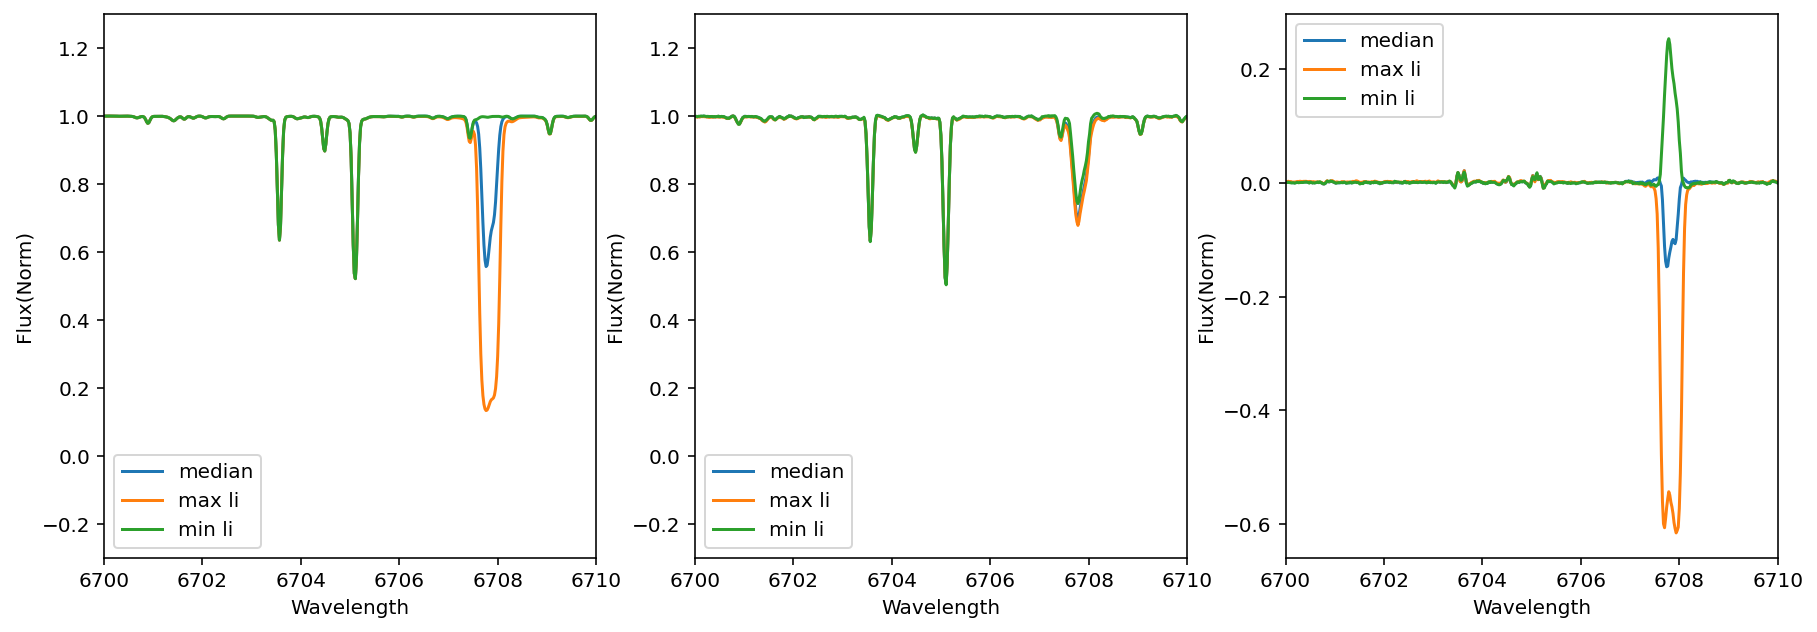

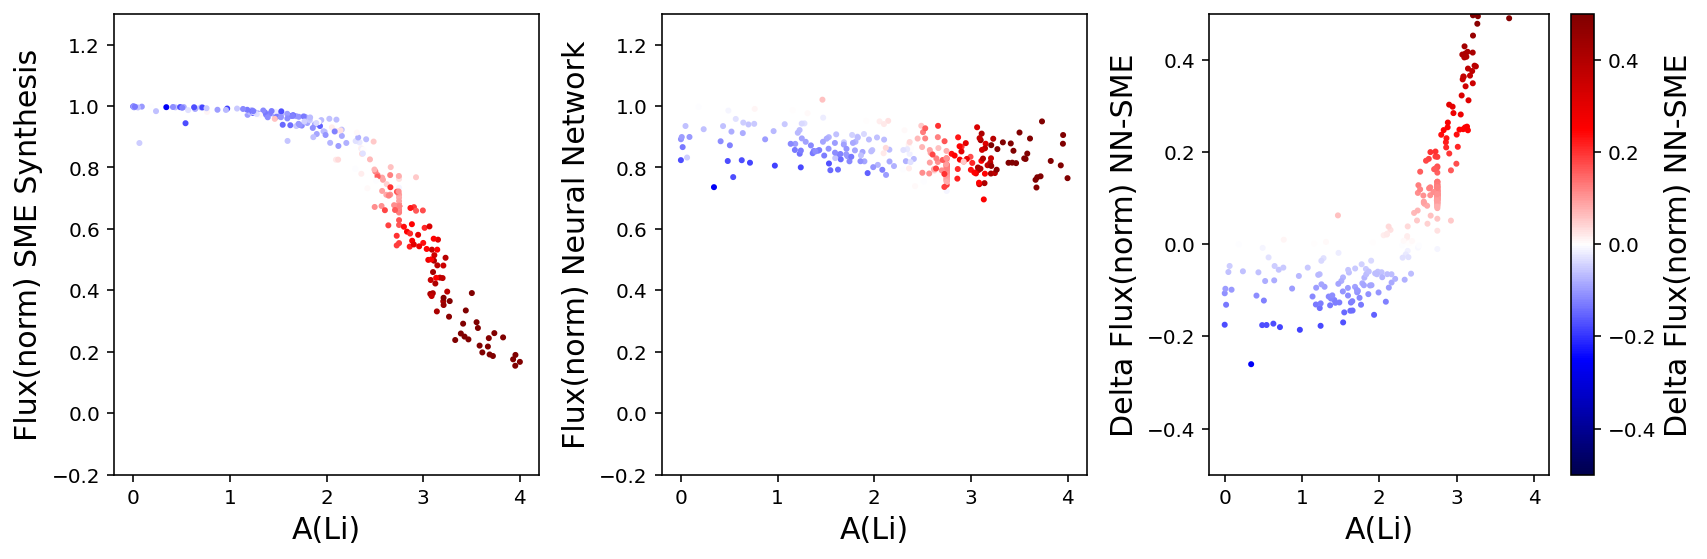

galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_300neurons_2layers_128batchsize.npz
7.4881815910339355


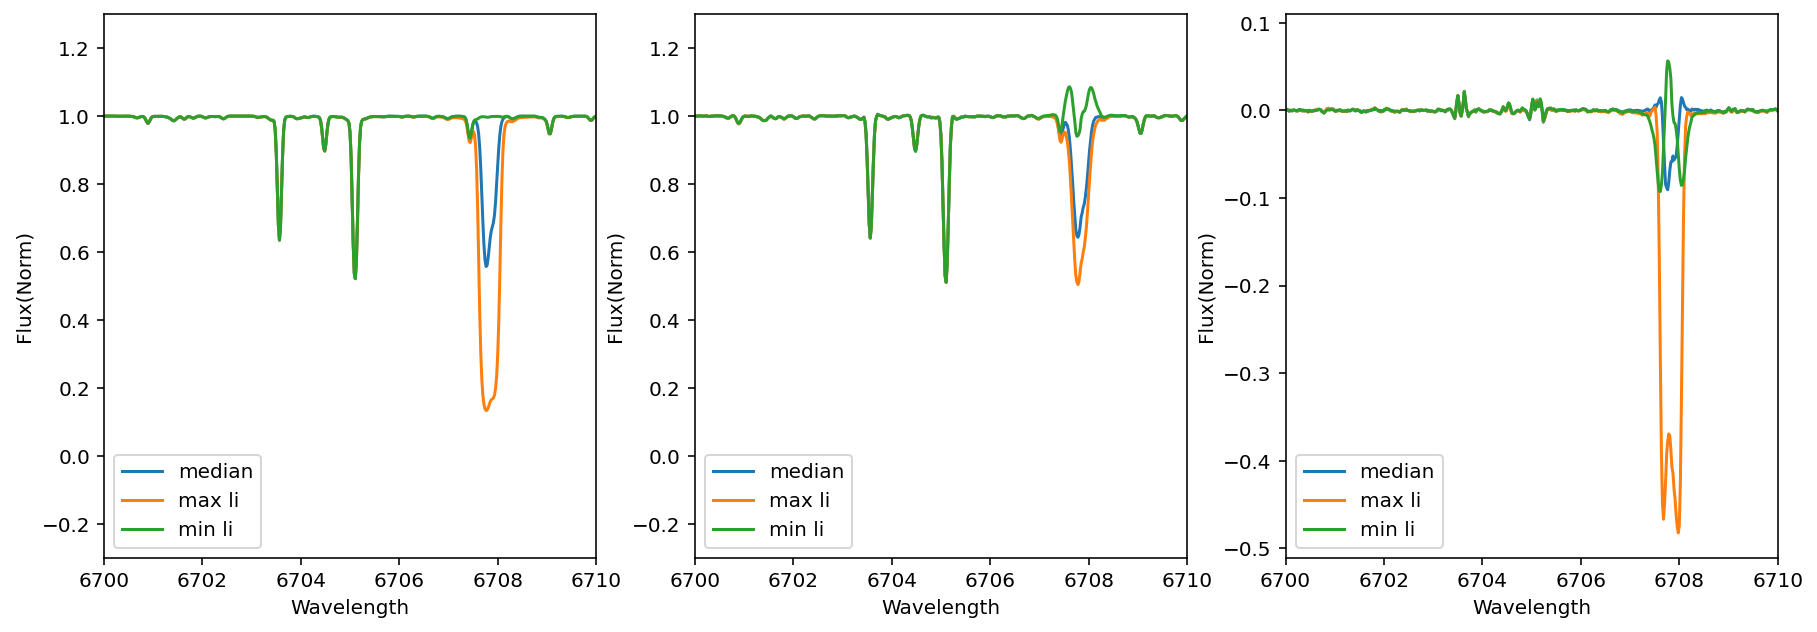

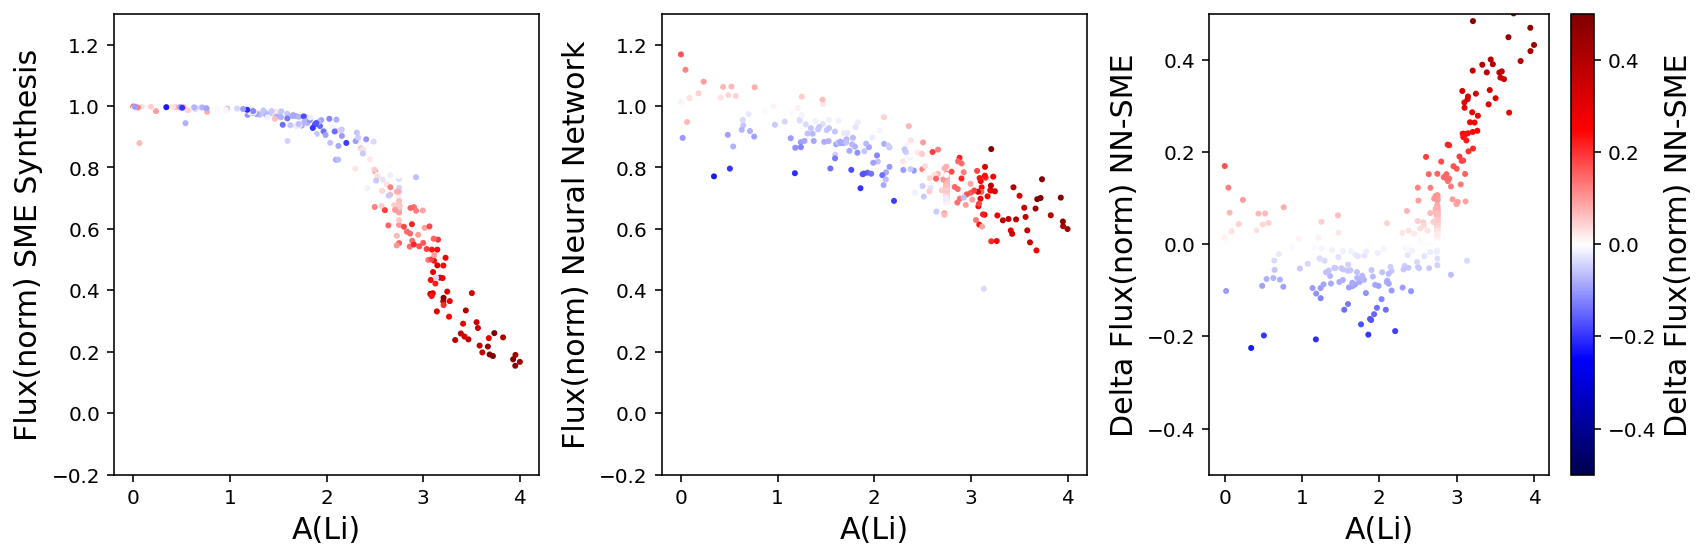

galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_300neurons_2layers_64batchsize.npz
5.740939378738403


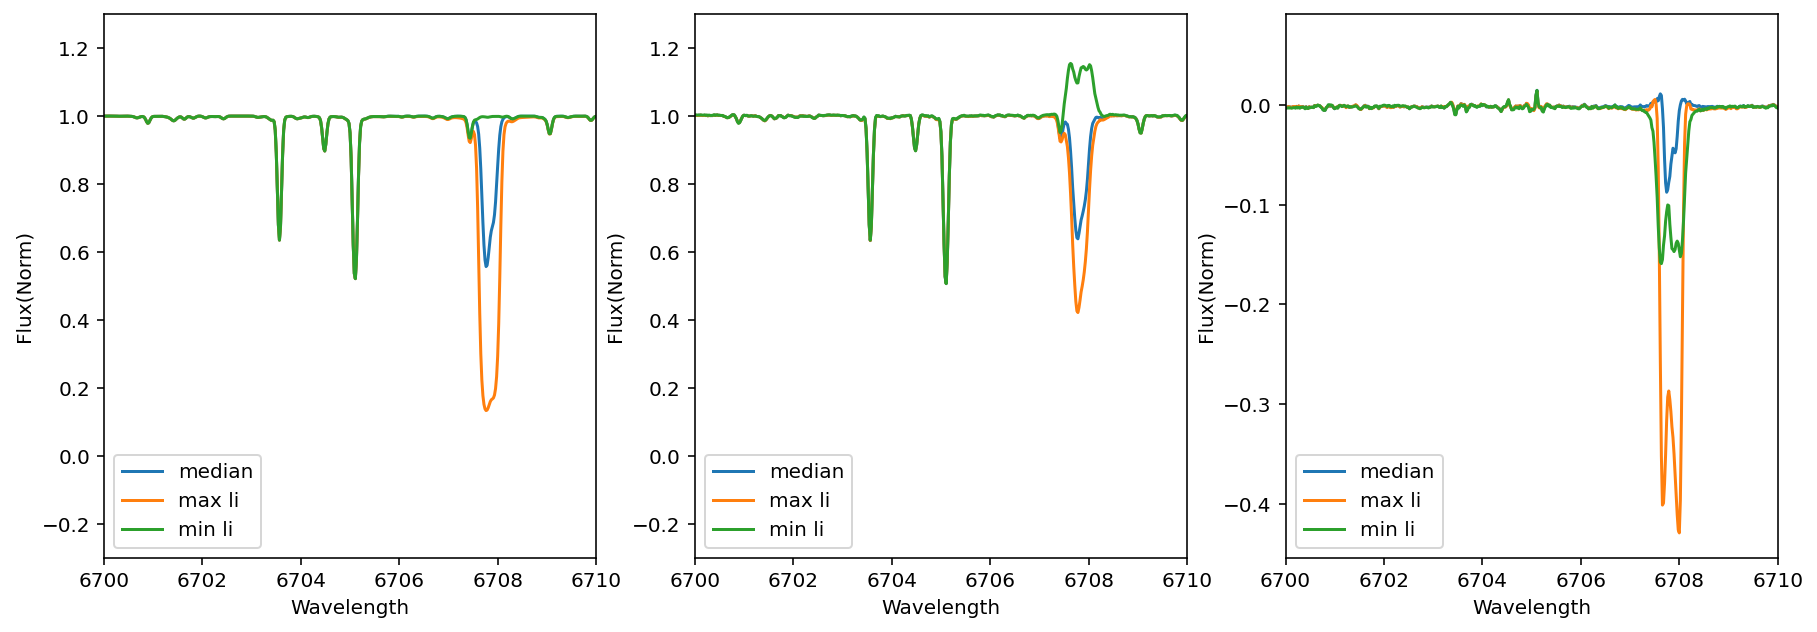

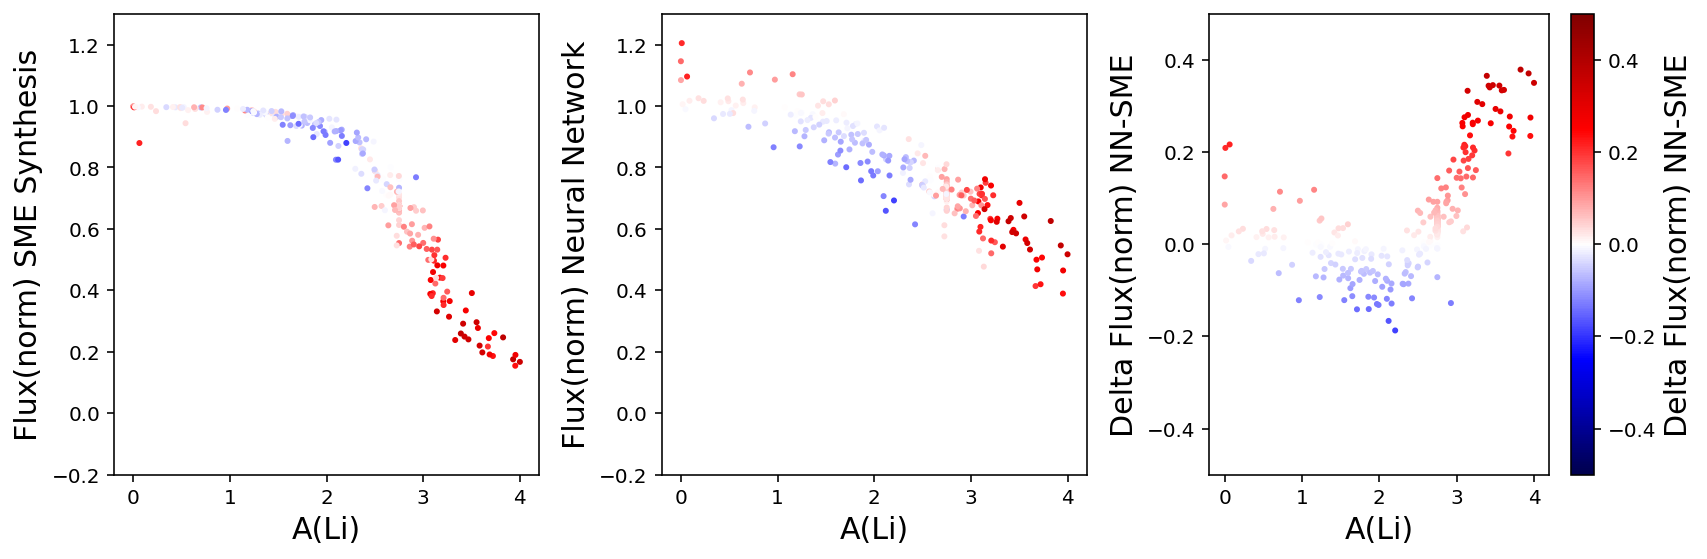

galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_300neurons_2layers_32batchsize.npz
7.044756650924683


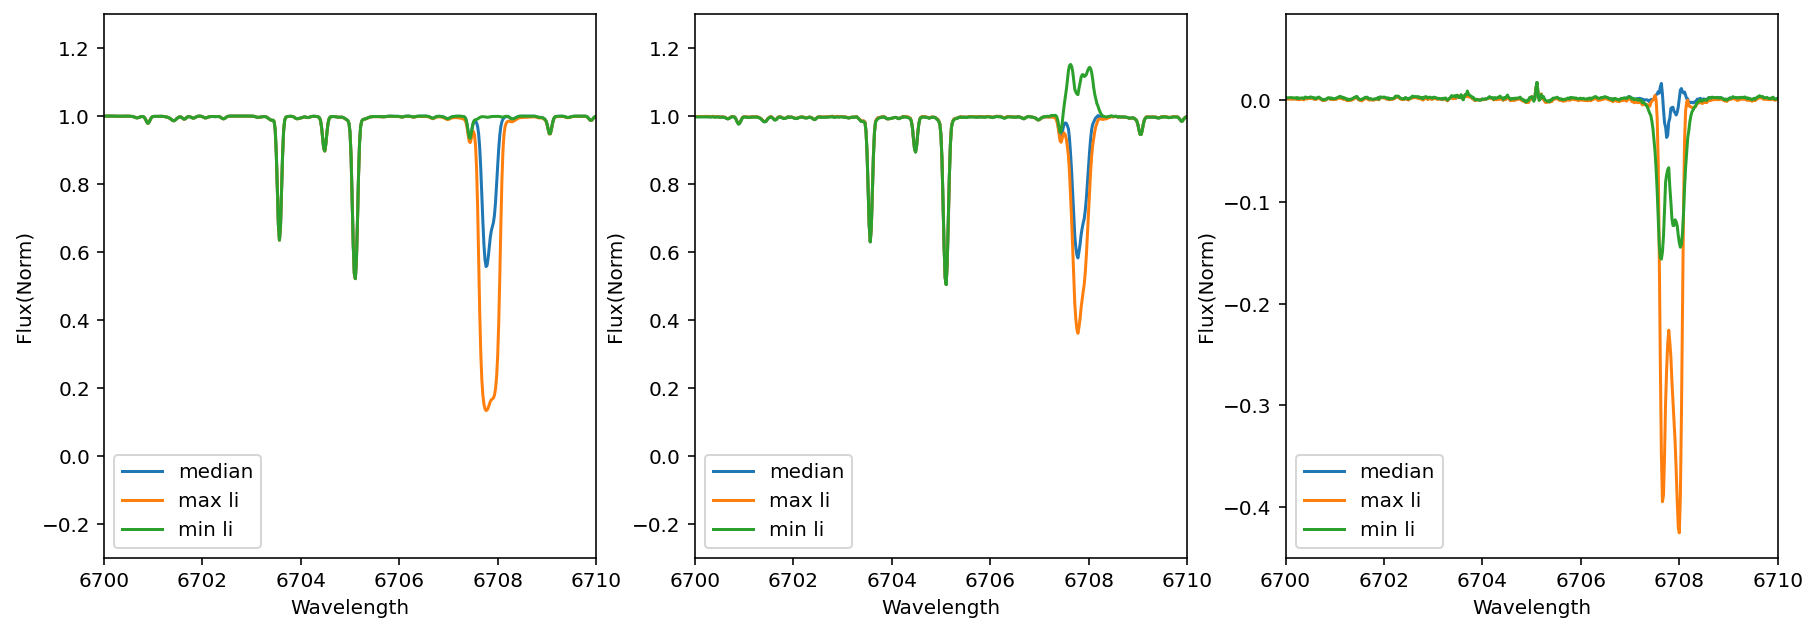

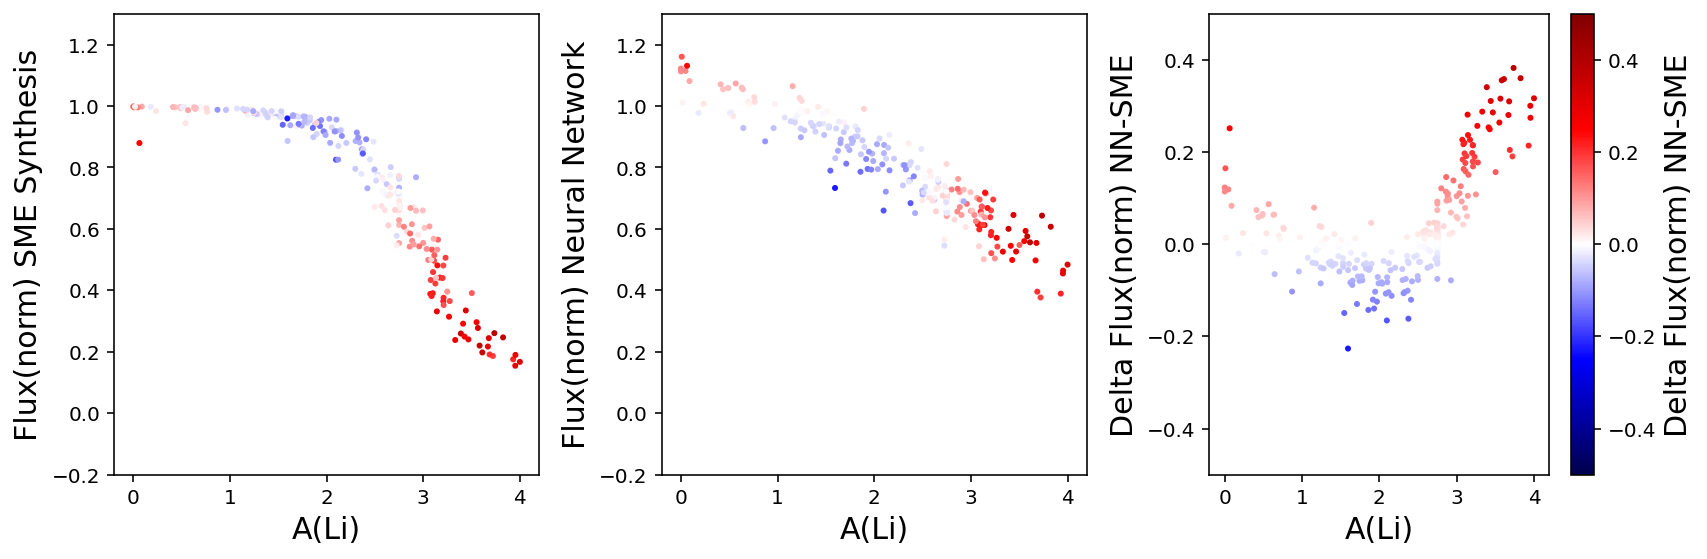

In [143]:
for model_name in [
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_300neurons_2layers_256batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_300neurons_2layers_128batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_300neurons_2layers_64batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_300neurons_2layers_32batchsize.npz'
]:
    plot_fluxes_and_return_them(model_name)

galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_300neurons_2layers_128batchsize.npz
5.528703451156616


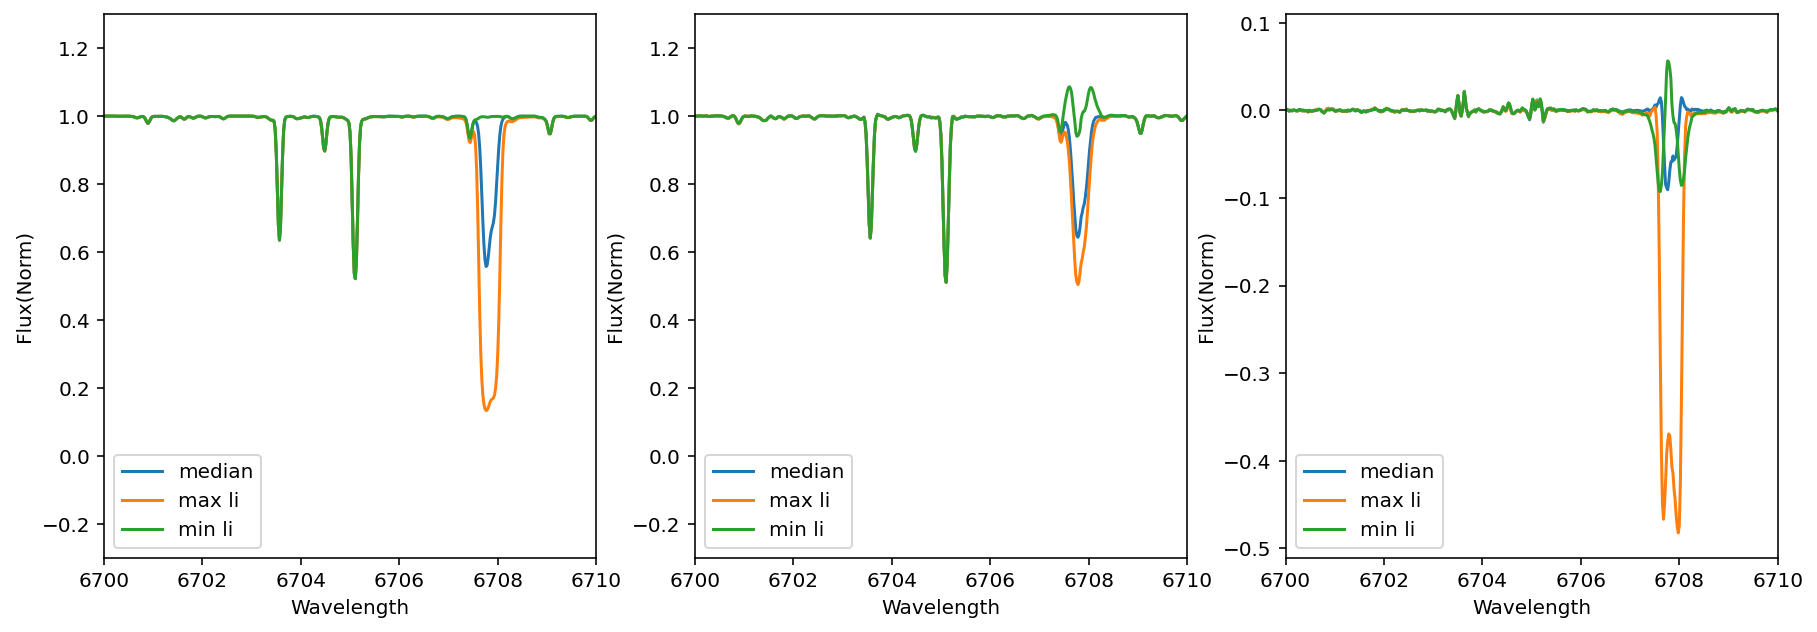

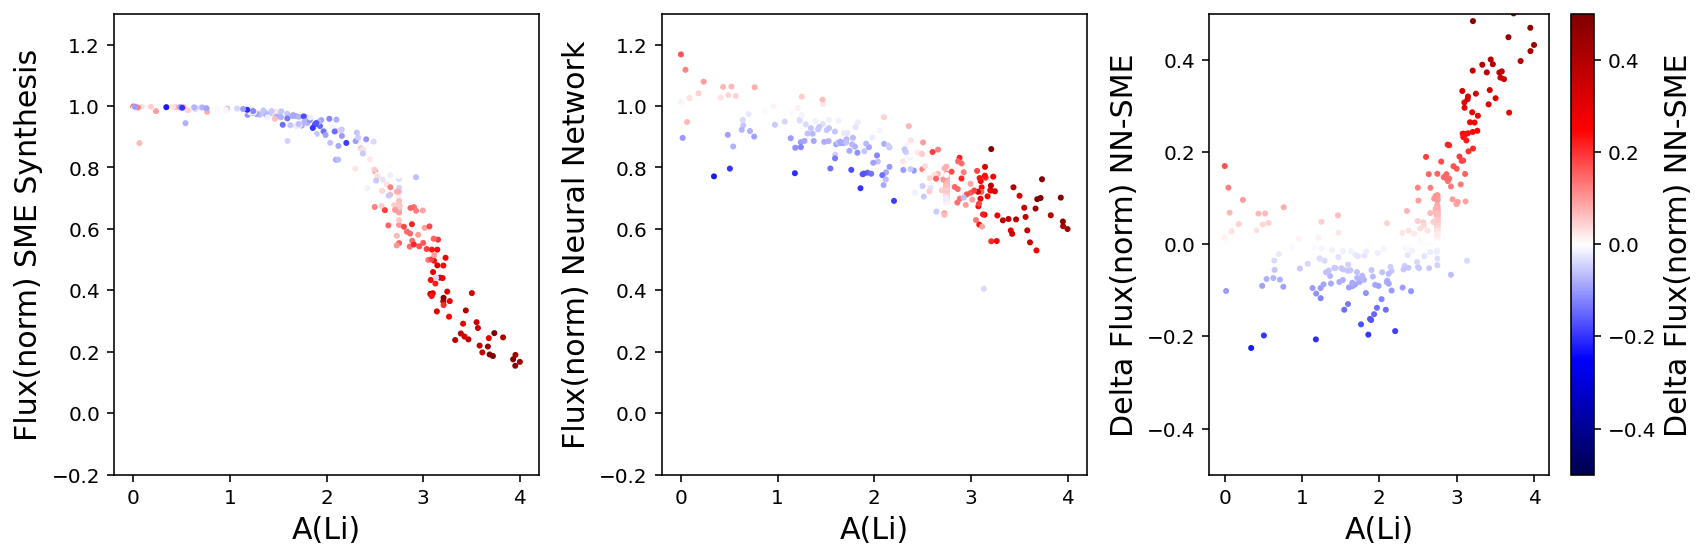

galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_600neurons_2layers_128batchsize.npz
11.243353128433228


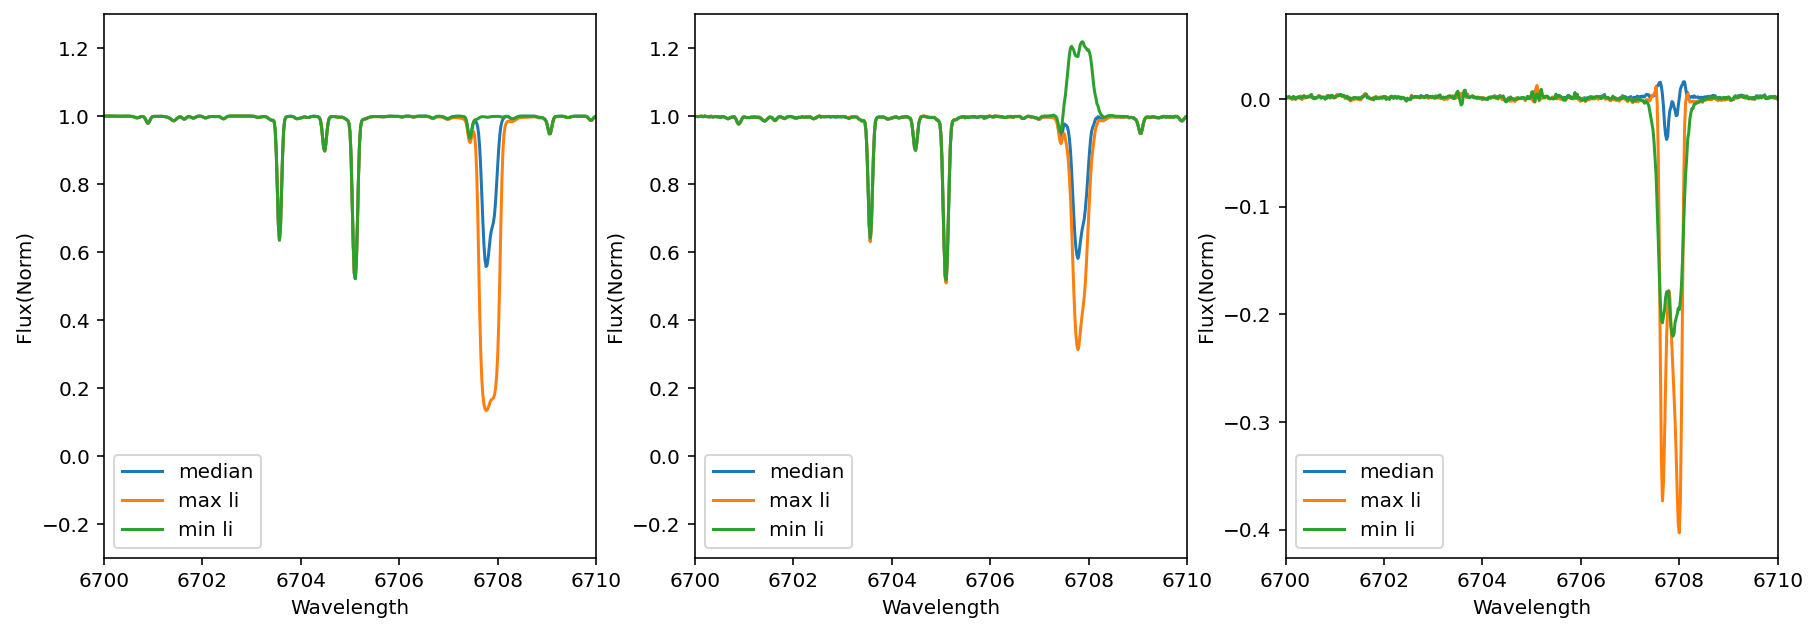

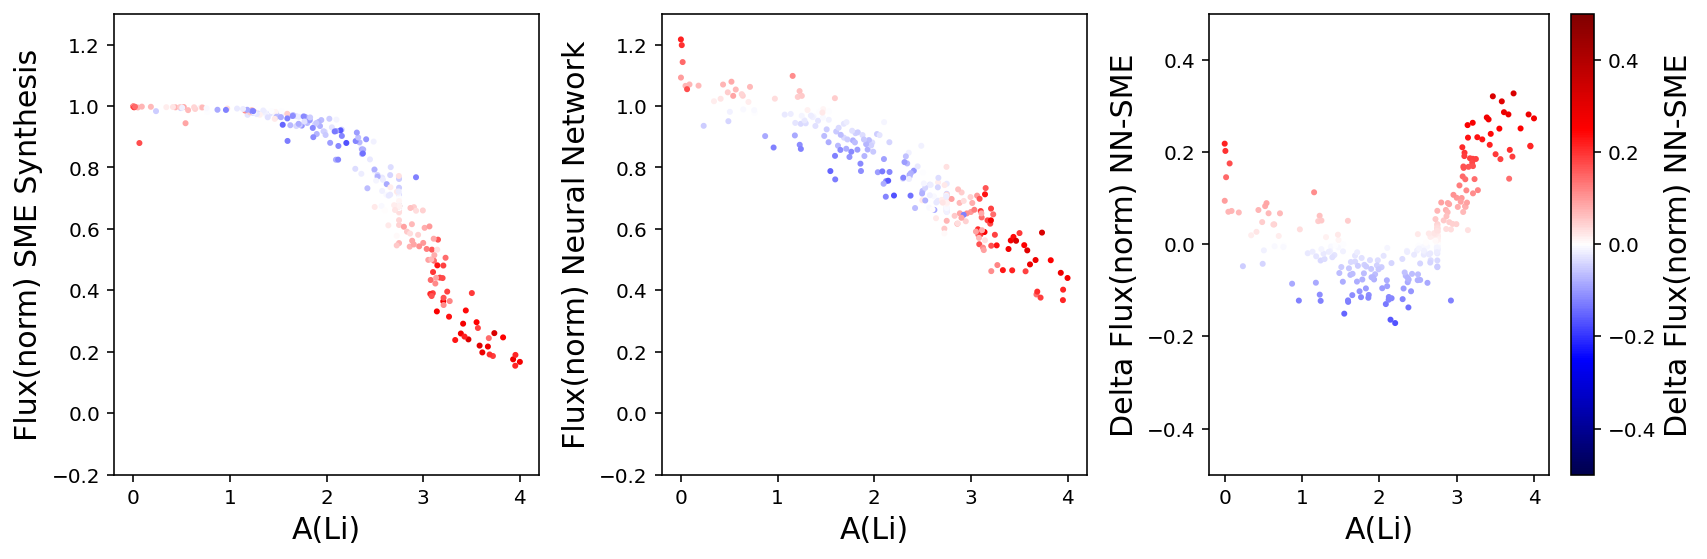

galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_900neurons_2layers_128batchsize.npz
16.639952182769775


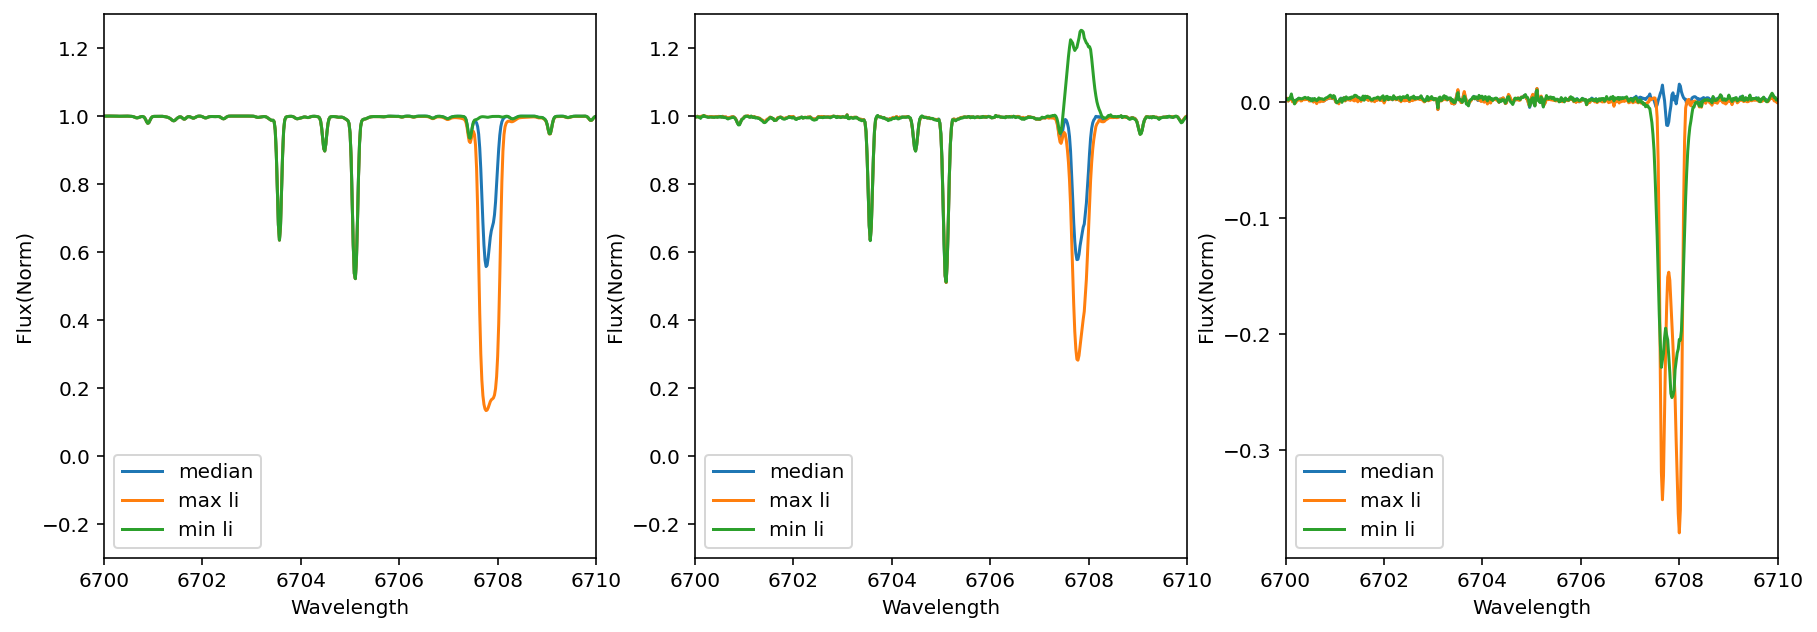

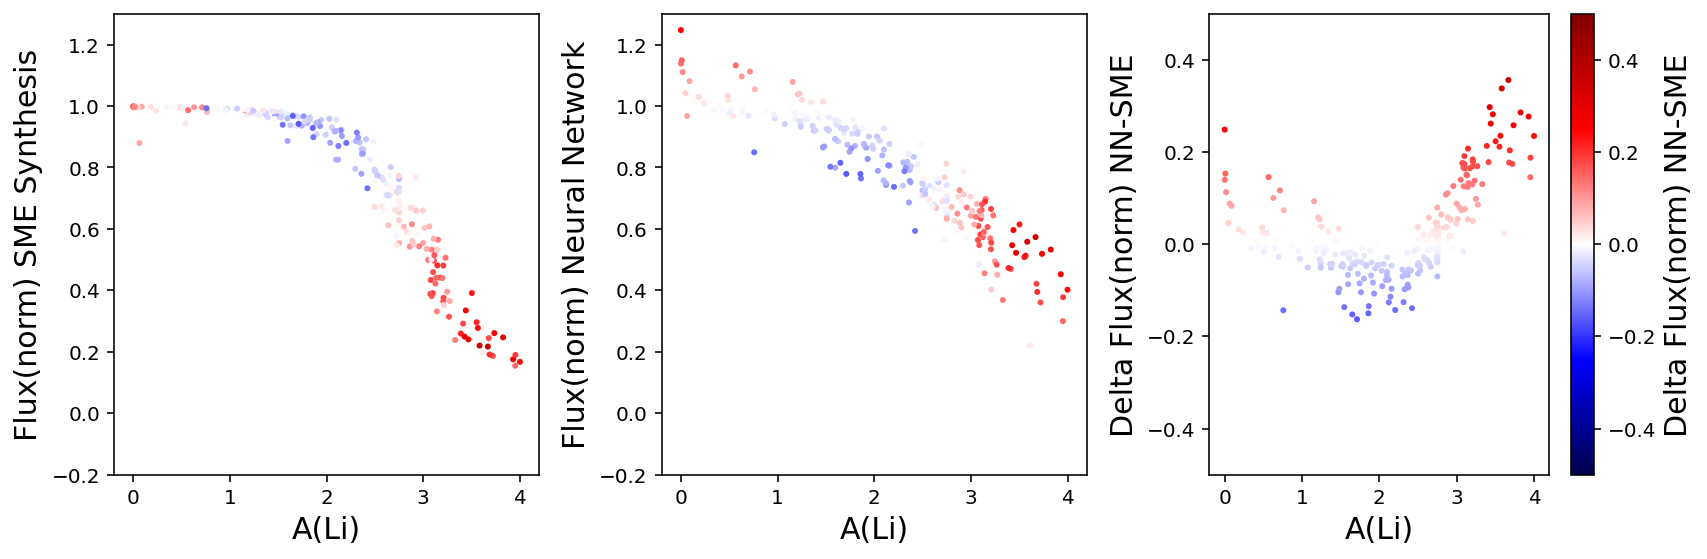

galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_1200neurons_2layers_128batchsize.npz
24.067869663238525


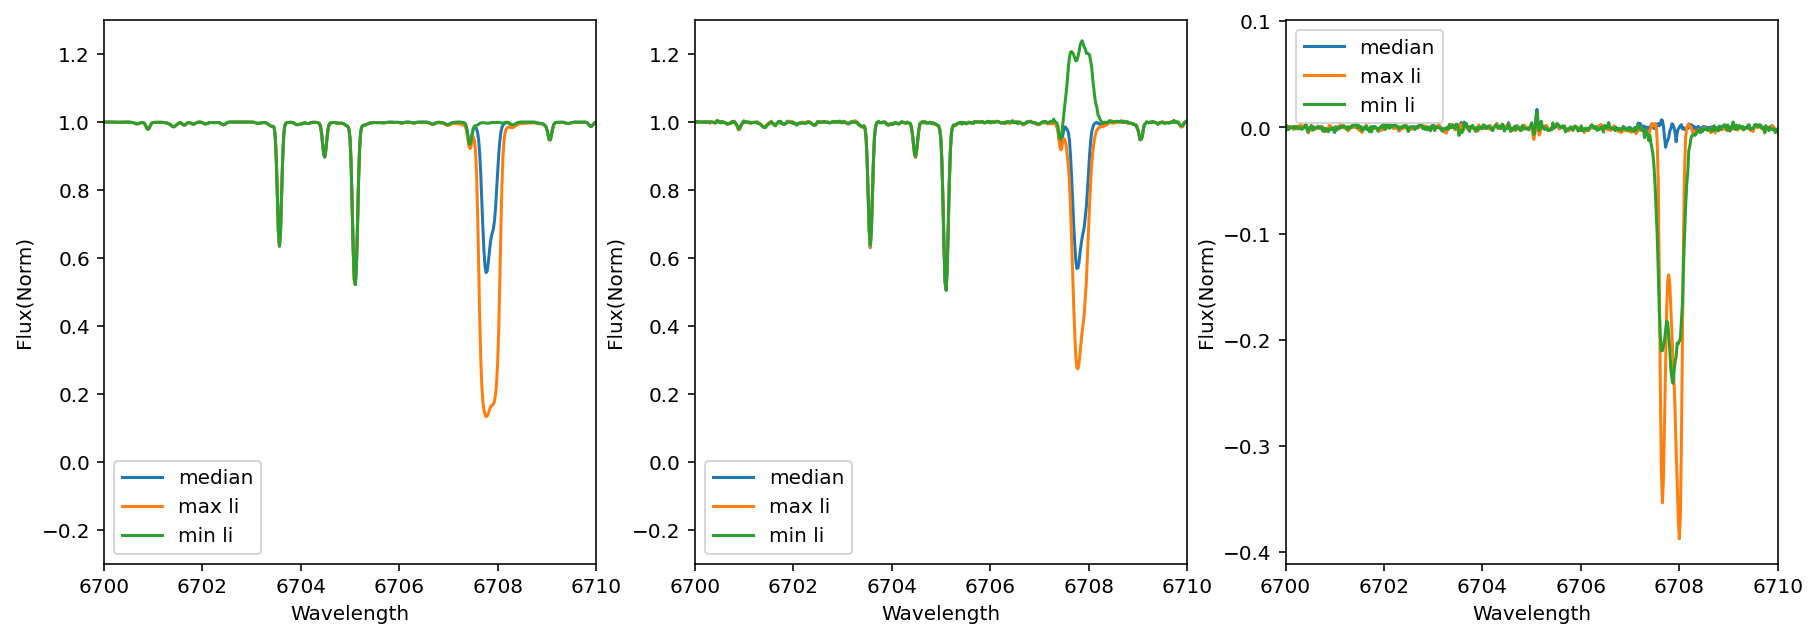

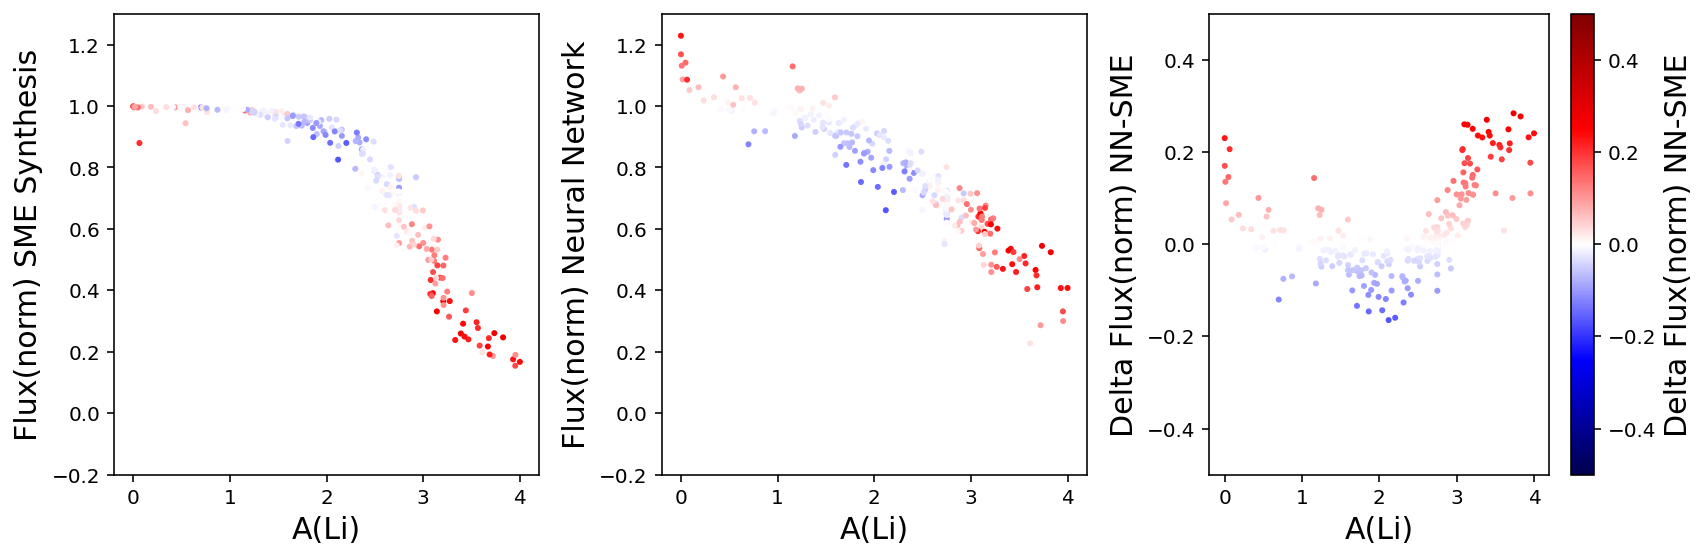

In [146]:
for model_name in [
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_300neurons_2layers_128batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_600neurons_2layers_128batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_900neurons_2layers_128batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_1200neurons_2layers_128batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_1500neurons_2layers_128batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_1800neurons_2layers_128batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_2100neurons_2layers_128batchsize.npz'
]:
    plot_fluxes_and_return_them(model_name)

galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_2100neurons_2layers_128batchsize.npz
42.77397322654724


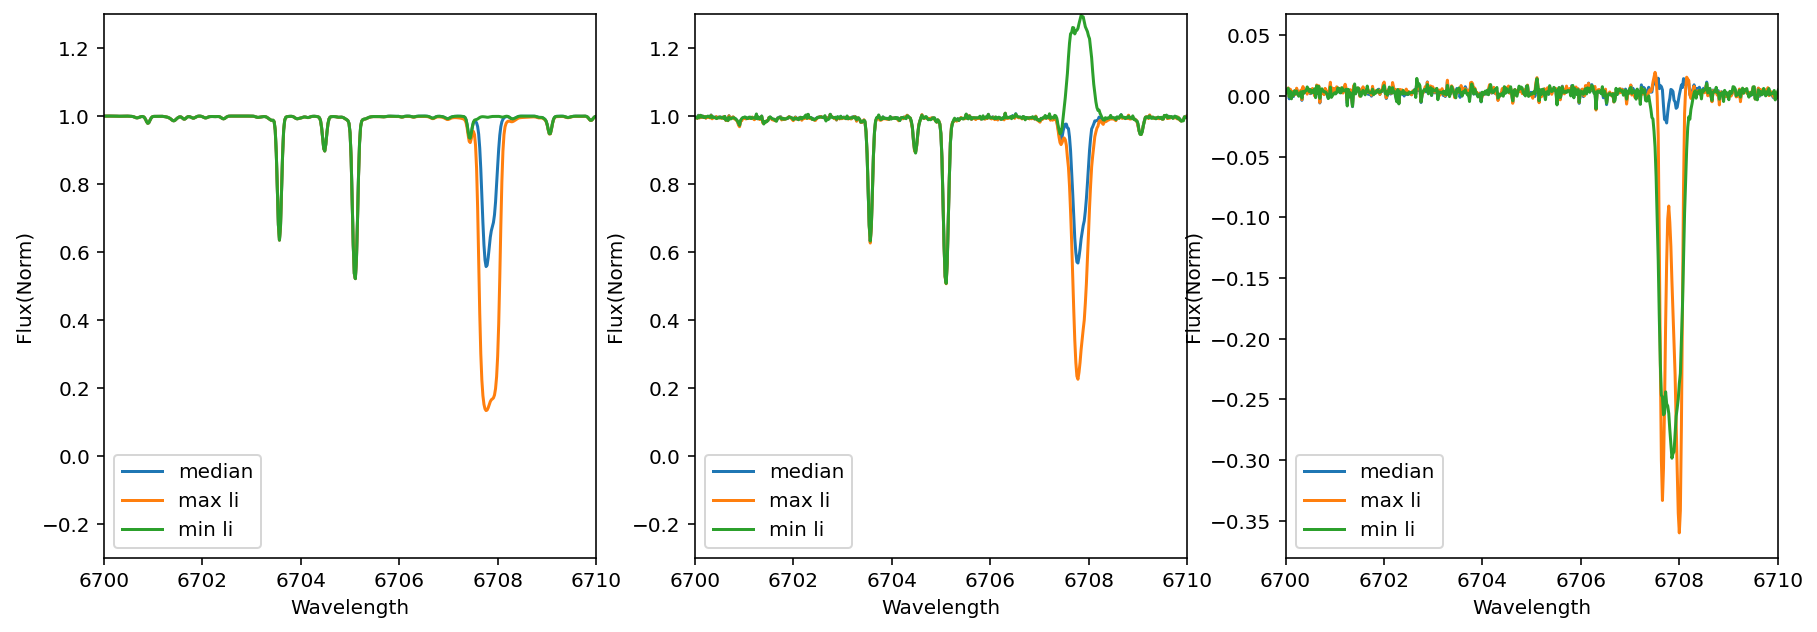

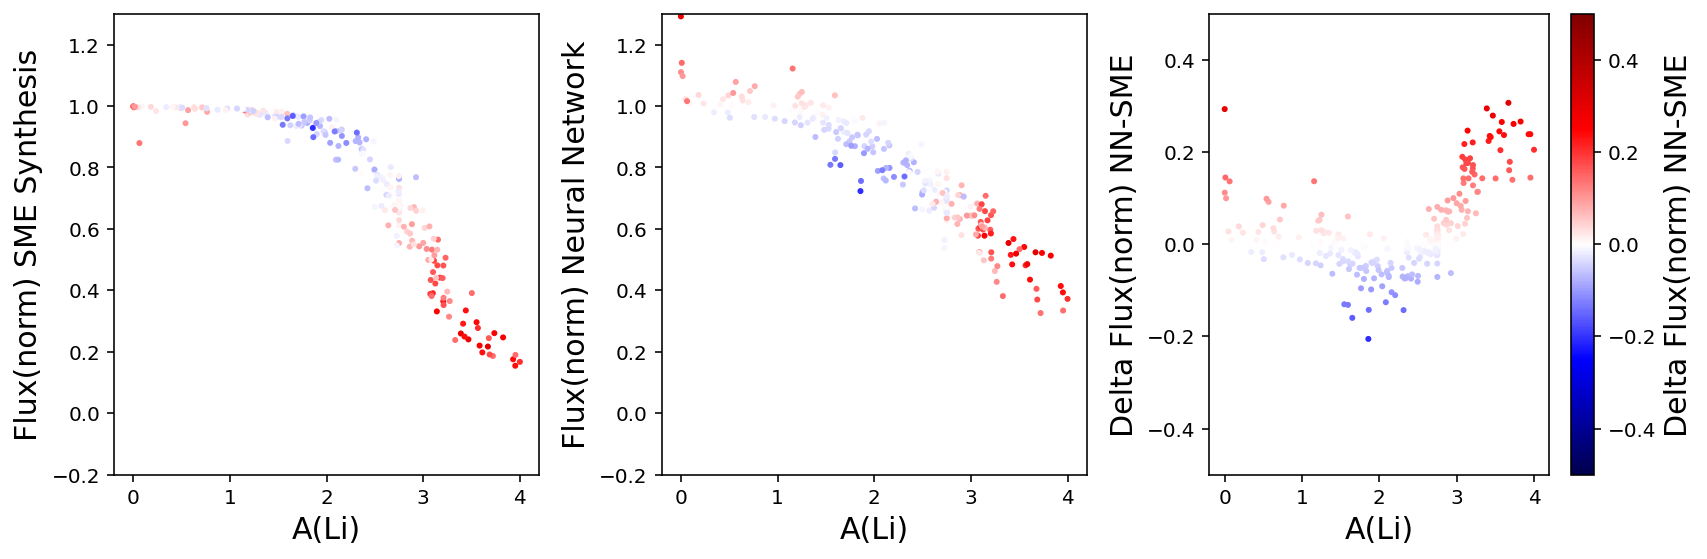

In [155]:
for model_name in [
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_1500neurons_2layers_128batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_1800neurons_2layers_128batchsize.npz',
    'galah_dr4_neutral_network_3x3x3_5750_4.50_0.00_36labels_2100neurons_2layers_128batchsize.npz'
]:
    plot_fluxes_and_return_them(model_name)